In [ ]:
%%capture
!pip install pandas fiona shapely pyproj rtree
!pip install geopandas



In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gdp


In [ ]:
from google.colab import files
  
  


## Rohdaten einlesen

In [ ]:
#Formatier float
uploaded = files.upload()
pd.set_option("float_format", "{:f}".format)
raw_data = pd.read_csv("/content/scrubbed.csv",low_memory=False)
raw_data


Saving scrubbed.csv to scrubbed (1).csv


,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611
...,...,...,...,...,...,...,...,...,...,...,...
80327,9/9/2013 21:15,nashville,tn,us,light,600,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.1658333,-86.784444
80328,9/9/2013 22:00,boise,id,us,circle,1200,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.6136111,-116.202500
80329,9/9/2013 22:00,napa,ca,us,other,1200,hour,Napa UFO&#44,9/30/2013,38.2972222,-122.284444
80330,9/9/2013 22:20,vienna,va,us,circle,5,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.9011111,-77.265556


## Datenreinigung und Vorbereitung

Entferne alle Daten, welche nicht in US sind

Array von https://www.kaggle.com/code/abigaillarion/ufo-reports-in-united-states ( zuletzt besucht am 03.01.2022)


In [ ]:
states = np.asarray(["ak", "al", "ar", "az", "ca", "co", "ct", "dc", "de", "fl", "ga",
                        "hi", "ia", "id", "il", "in", "ks", "ky", "la", "ma", "md", "me",
                        "mi", "mn", "mo", "ms", "mt", "nc", "nd", "ne", "nh", "nj", "nm",
                        "nv", "ny", "oh", "ok", "or", "pa", "ri", "sc", "sd", "tn", "tx",
                        "ut", "va", "vt", "wa", "wi", "wv", "wy"])

raw_data = raw_data[(raw_data.country  == "us") | (raw_data.state.isin(states) == True) ]

raw_data

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611
5,10/10/1961 19:00,bristol,tn,us,sphere,300,5 minutes,My father is now 89 my brother 52 the girl wit...,4/27/2007,36.5950000,-82.188889
...,...,...,...,...,...,...,...,...,...,...,...
80327,9/9/2013 21:15,nashville,tn,us,light,600,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.1658333,-86.784444
80328,9/9/2013 22:00,boise,id,us,circle,1200,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.6136111,-116.202500
80329,9/9/2013 22:00,napa,ca,us,other,1200,hour,Napa UFO&#44,9/30/2013,38.2972222,-122.284444
80330,9/9/2013 22:20,vienna,va,us,circle,5,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.9011111,-77.265556


In [ ]:
raw_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 70930 entries, 0 to 80331
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              70930 non-null  object 
 1   city                  70930 non-null  object 
 2   state                 70930 non-null  object 
 3   country               65125 non-null  object 
 4   shape                 69199 non-null  object 
 5   duration (seconds)    70930 non-null  object 
 6   duration (hours/min)  70930 non-null  object 
 7   comments              70917 non-null  object 
 8   date posted           70930 non-null  object 
 9   latitude              70930 non-null  object 
 10  longitude             70930 non-null  float64
dtypes: float64(1), object(10)
memory usage: 6.5+ MB


In [ ]:
%%capture

raw_data.rename(columns={"longitude ": "longitude"})
raw_data["latitude"] = raw_data["latitude"].str.replace("33q.200088", "33.200088")

raw_data["latitude"] = pd.to_numeric(raw_data["latitude"], downcast="float")


In [ ]:
raw_data.dtypes

datetime                 object
city                     object
state                    object
country                  object
shape                    object
duration (seconds)       object
duration (hours/min)     object
comments                 object
date posted              object
latitude                float32
longitude               float64
dtype: object

Plotte alle Sichtungen um Sicherzustellen, dass nur US im Data Frame sind

In [ ]:


raw_data = raw_data.rename(columns={"longitude ": "longitude"})


In [ ]:
df_geo = gdp.GeoDataFrame(raw_data,geometry=gdp.points_from_xy(raw_data.longitude, raw_data.latitude ))
df_geo


,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,geometry
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.883055,-97.941111,POINT (-97.94111 29.88305)
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.384211,-98.581082,POINT (-98.58108 29.38421)
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833,POINT (-96.64583 28.97833)
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611,POINT (-157.80361 21.41806)
5,10/10/1961 19:00,bristol,tn,us,sphere,300,5 minutes,My father is now 89 my brother 52 the girl wit...,4/27/2007,36.595001,-82.188889,POINT (-82.18889 36.59500)
...,...,...,...,...,...,...,...,...,...,...,...,...
80327,9/9/2013 21:15,nashville,tn,us,light,600,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.165833,-86.784444,POINT (-86.78444 36.16583)
80328,9/9/2013 22:00,boise,id,us,circle,1200,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.613609,-116.202500,POINT (-116.20250 43.61361)
80329,9/9/2013 22:00,napa,ca,us,other,1200,hour,Napa UFO&#44,9/30/2013,38.297222,-122.284444,POINT (-122.28444 38.29722)
80330,9/9/2013 22:20,vienna,va,us,circle,5,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.901112,-77.265556,POINT (-77.26556 38.90111)


In [ ]:
world_data = gdp.read_file(gdp.datasets.get_path("naturalearth_lowres"))

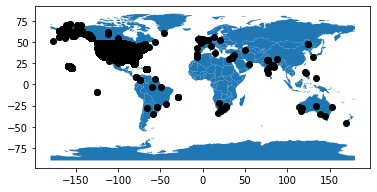

In [ ]:
axis = world_data.plot()
df_geo.plot(ax = axis,  color="black")


Entferne alle Punkte außerhalb der USA

In [ ]:
%%capture

#Quelle: https://gis.stackexchange.com/questions/208546/check-if-a-point-falls-within-a-multipolygon-with-python (zuletzt besucht am 03.01.2022) 
us = world_data[world_data.name == "United States of America"]
from geopandas.tools import sjoin
pointInPolys = sjoin(df_geo, us, how="left")
grouped = pointInPolys.groupby("index_right")
d= grouped.apply(lambda x: x) 

In [ ]:
d


,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,geometry,index_right,pop_est,continent,name,iso_a3,gdp_md_est
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.883055,-97.941111,POINT (-97.94111 29.88305),4.000000,326625791.000000,North America,United States of America,USA,18560000.000000
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.384211,-98.581082,POINT (-98.58108 29.38421),4.000000,326625791.000000,North America,United States of America,USA,18560000.000000
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833,POINT (-96.64583 28.97833),4.000000,326625791.000000,North America,United States of America,USA,18560000.000000
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611,POINT (-157.80361 21.41806),4.000000,326625791.000000,North America,United States of America,USA,18560000.000000
5,10/10/1961 19:00,bristol,tn,us,sphere,300,5 minutes,My father is now 89 my brother 52 the girl wit...,4/27/2007,36.595001,-82.188889,POINT (-82.18889 36.59500),4.000000,326625791.000000,North America,United States of America,USA,18560000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80327,9/9/2013 21:15,nashville,tn,us,light,600,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.165833,-86.784444,POINT (-86.78444 36.16583),4.000000,326625791.000000,North America,United States of America,USA,18560000.000000
80328,9/9/2013 22:00,boise,id,us,circle,1200,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.613609,-116.202500,POINT (-116.20250 43.61361),4.000000,326625791.000000,North America,United States of America,USA,18560000.000000
80329,9/9/2013 22:00,napa,ca,us,other,1200,hour,Napa UFO&#44,9/30/2013,38.297222,-122.284444,POINT (-122.28444 38.29722),4.000000,326625791.000000,North America,United States of America,USA,18560000.000000
80330,9/9/2013 22:20,vienna,va,us,circle,5,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.901112,-77.265556,POINT (-77.26556 38.90111),4.000000,326625791.000000,North America,United States of America,USA,18560000.000000


Überprüfe ob alle Punkte außerhalb der USA entfernt sind

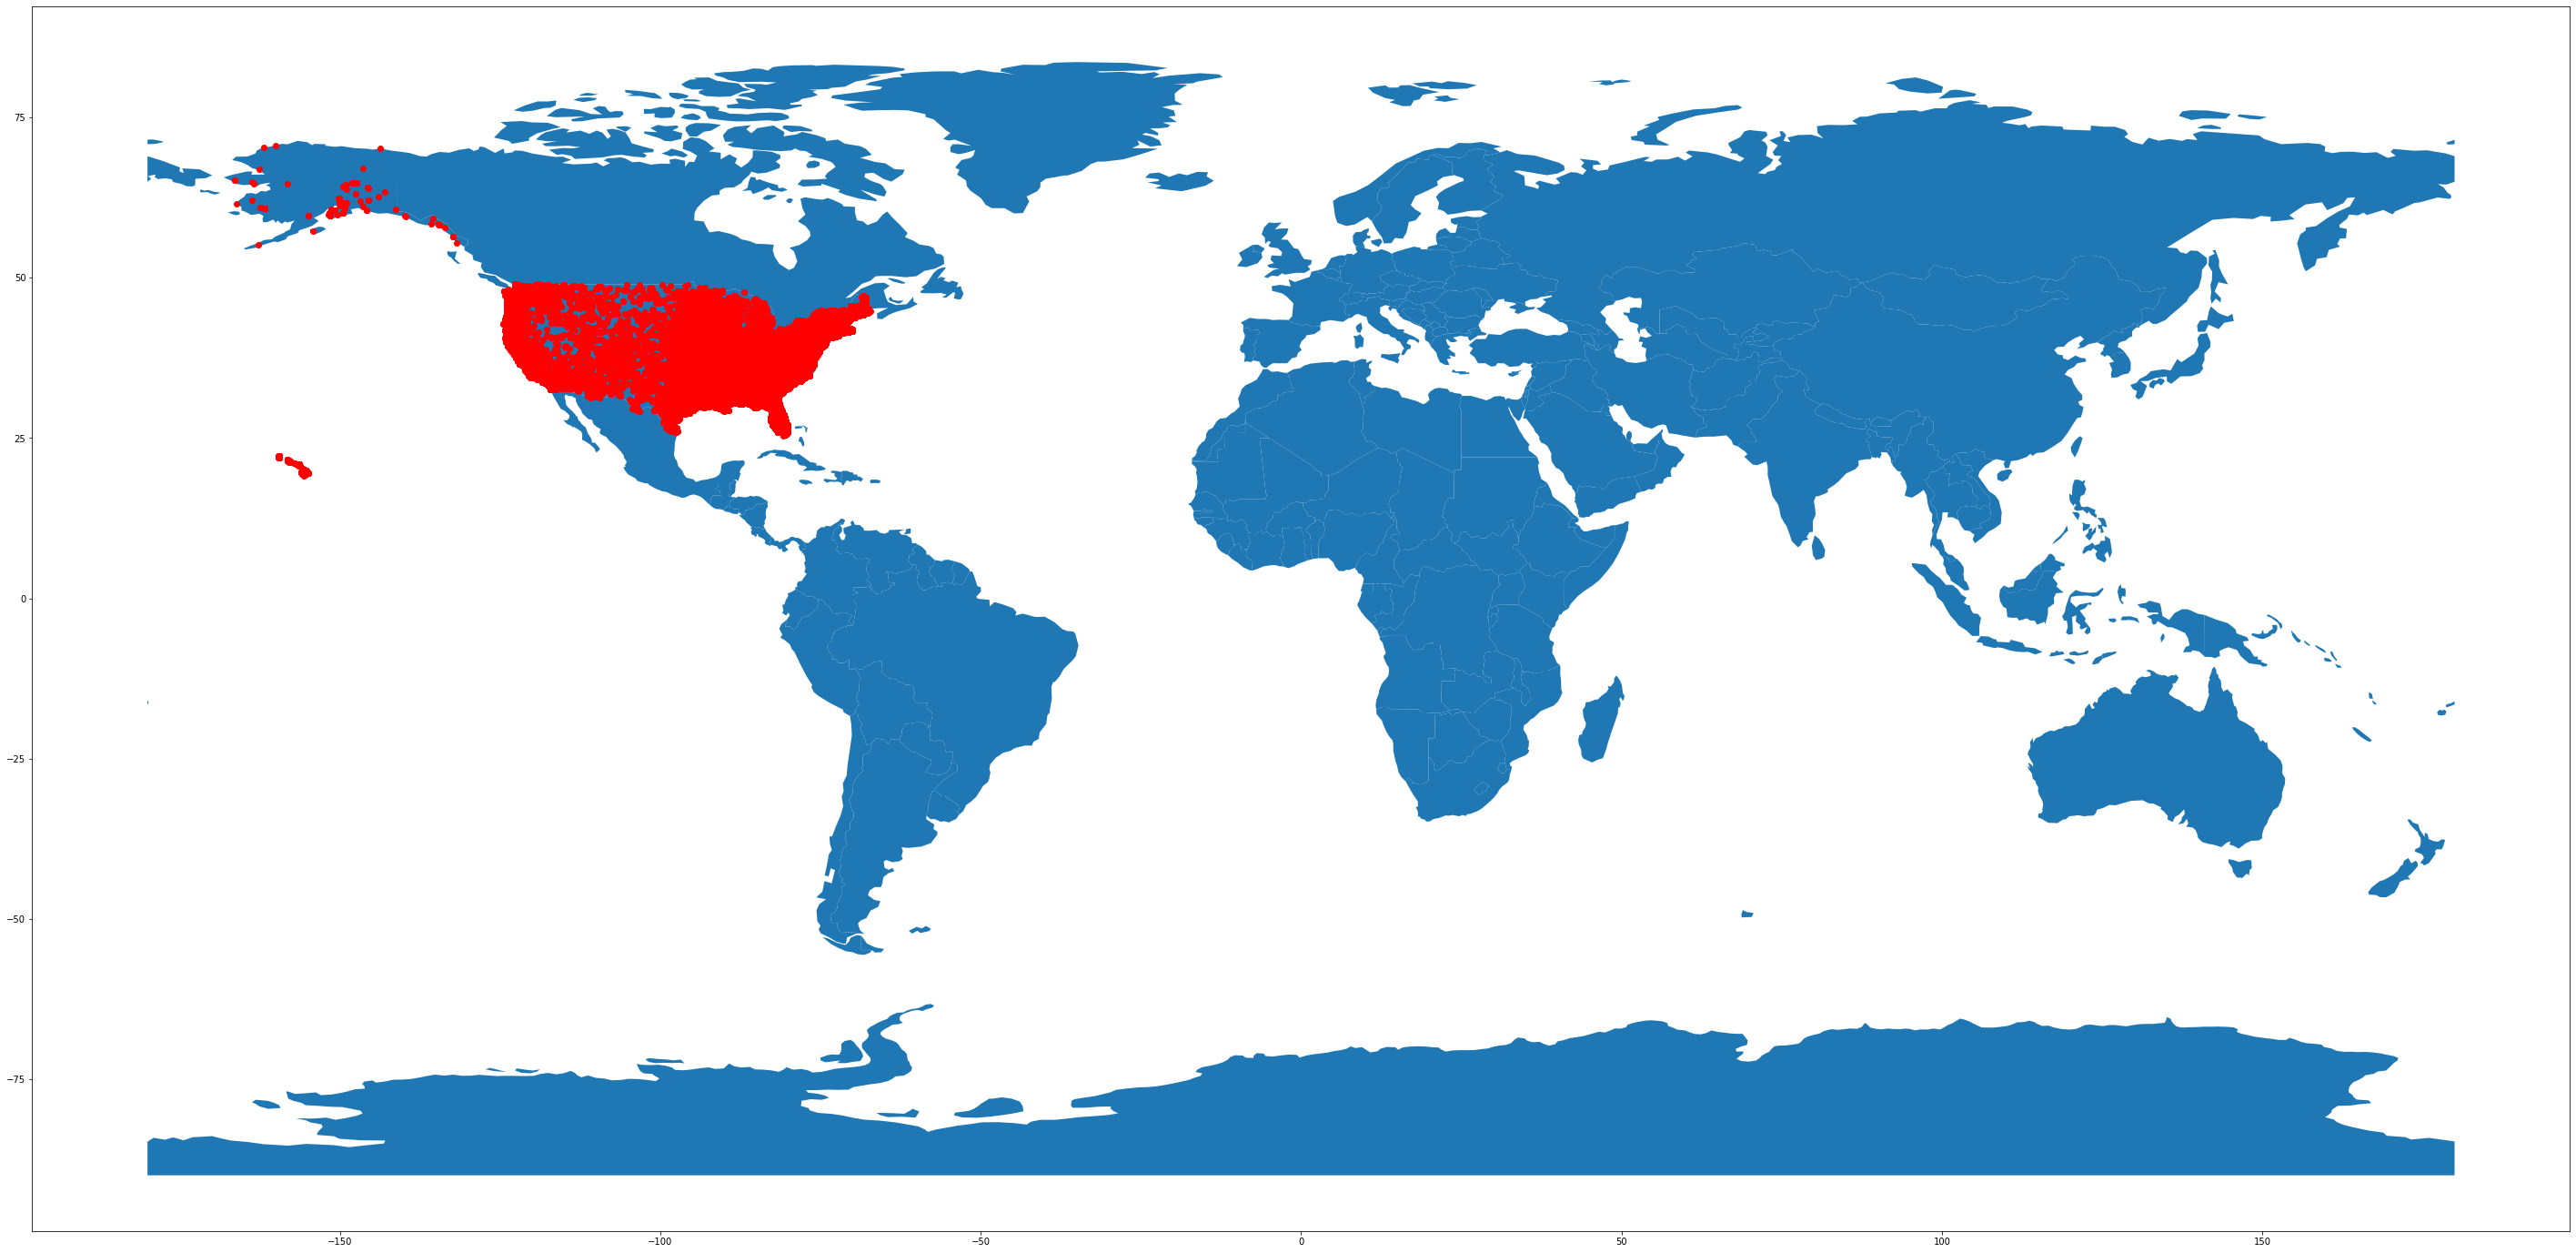

In [ ]:
world = world_data.plot(figsize=(50,50))
d.plot(ax = world, color = "red")

Zoome ran, um die Grenzregion näher zu betrachten

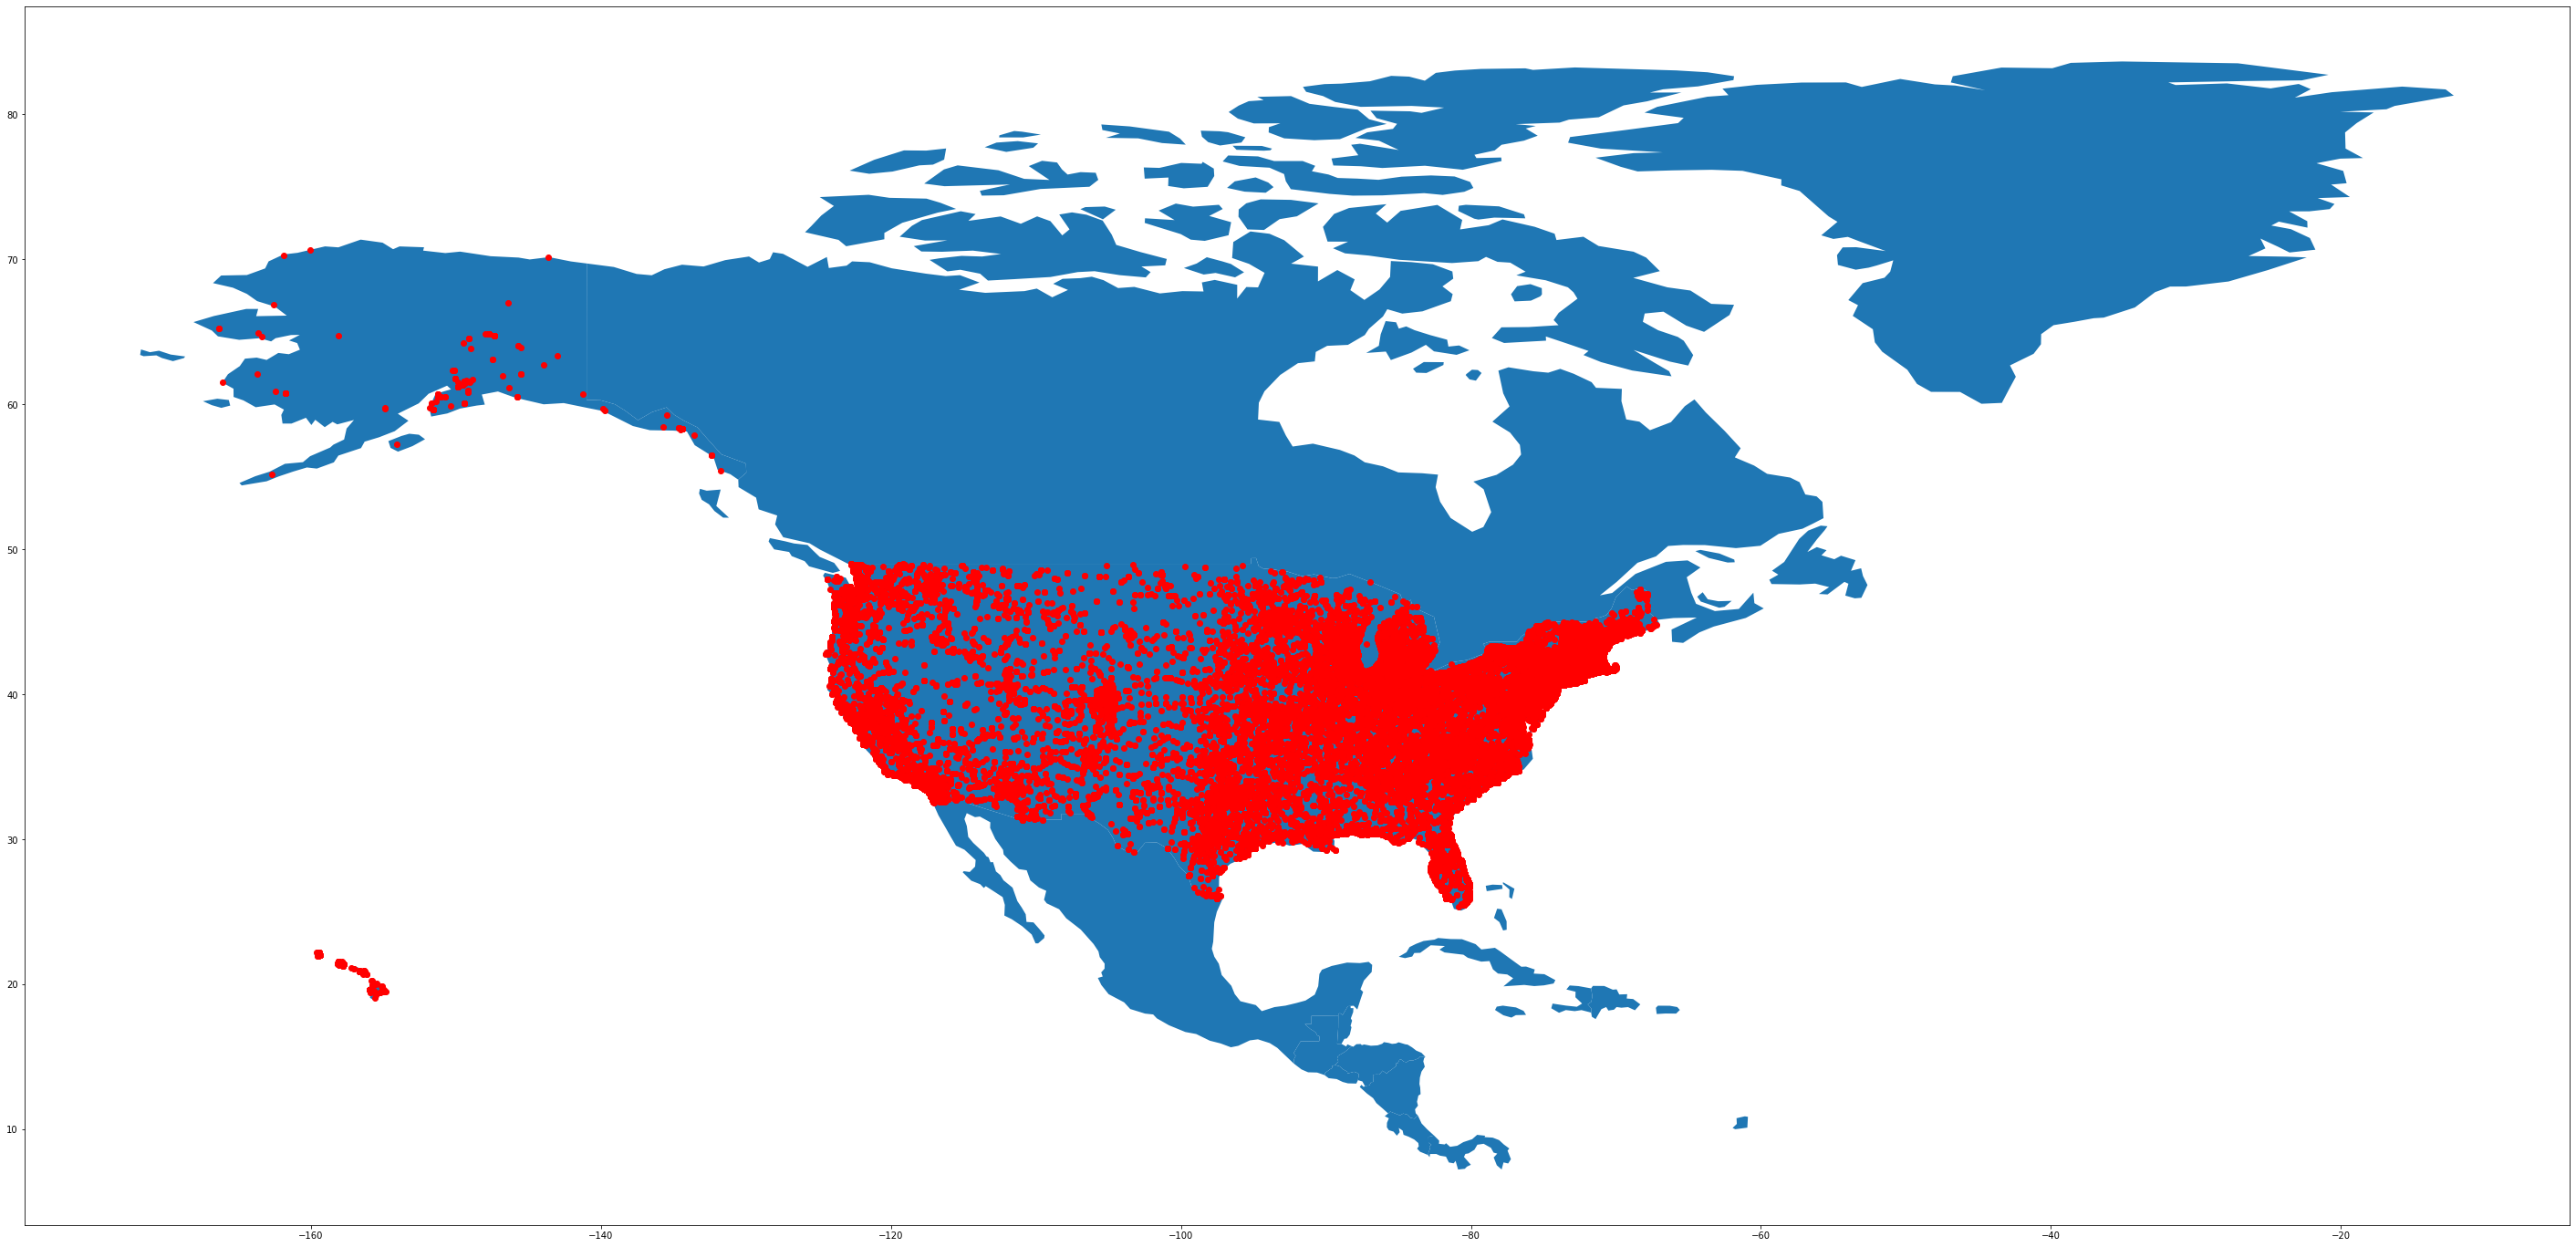

In [ ]:
na = world_data[world_data.continent == "North America"].plot(figsize=(50,50))
d.plot(ax = na, color = "red")

In [ ]:
raw_data = pd.DataFrame(d)
raw_data

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,geometry,index_right,pop_est,continent,name,iso_a3,gdp_md_est
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.883055,-97.941111,POINT (-97.94111 29.88305),4.000000,326625791.000000,North America,United States of America,USA,18560000.000000
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.384211,-98.581082,POINT (-98.58108 29.38421),4.000000,326625791.000000,North America,United States of America,USA,18560000.000000
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833,POINT (-96.64583 28.97833),4.000000,326625791.000000,North America,United States of America,USA,18560000.000000
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611,POINT (-157.80361 21.41806),4.000000,326625791.000000,North America,United States of America,USA,18560000.000000
5,10/10/1961 19:00,bristol,tn,us,sphere,300,5 minutes,My father is now 89 my brother 52 the girl wit...,4/27/2007,36.595001,-82.188889,POINT (-82.18889 36.59500),4.000000,326625791.000000,North America,United States of America,USA,18560000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80327,9/9/2013 21:15,nashville,tn,us,light,600,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.165833,-86.784444,POINT (-86.78444 36.16583),4.000000,326625791.000000,North America,United States of America,USA,18560000.000000
80328,9/9/2013 22:00,boise,id,us,circle,1200,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.613609,-116.202500,POINT (-116.20250 43.61361),4.000000,326625791.000000,North America,United States of America,USA,18560000.000000
80329,9/9/2013 22:00,napa,ca,us,other,1200,hour,Napa UFO&#44,9/30/2013,38.297222,-122.284444,POINT (-122.28444 38.29722),4.000000,326625791.000000,North America,United States of America,USA,18560000.000000
80330,9/9/2013 22:20,vienna,va,us,circle,5,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.901112,-77.265556,POINT (-77.26556 38.90111),4.000000,326625791.000000,North America,United States of America,USA,18560000.000000


Lösche nicht benötigte Spalten




In [ ]:
raw_data.columns.values


array(['datetime', 'city', 'state', 'country', 'shape',
       'duration (seconds)', 'duration (hours/min)', 'comments',
       'date posted', 'latitude', 'longitude', 'geometry', 'index_right',
       'pop_est', 'continent', 'name', 'iso_a3', 'gdp_md_est'],
      dtype=object)

In [ ]:
raw_data
raw_data = raw_data.drop("comments",axis=1)
raw_data = raw_data.drop("date posted",axis=1)
raw_data = raw_data.drop("geometry",axis=1)
raw_data = raw_data.drop("index_right",axis=1)
raw_data = raw_data.drop("pop_est",axis=1)
raw_data = raw_data.drop("continent",axis=1)
raw_data = raw_data.drop("name",axis=1)
raw_data = raw_data.drop("iso_a3",axis=1)
raw_data = raw_data.drop("gdp_md_est",axis=1)


Analyse der leeren Werte

In [ ]:
raw_data.isnull().sum()

datetime                   0
city                       0
state                      0
country                 5453
shape                   1666
duration (seconds)         0
duration (hours/min)       0
latitude                   0
longitude                  0
dtype: int64

Lösche alle Zeilen mit leeren Werten in Spalte Shape



In [ ]:



raw_data = raw_data[raw_data["shape"].notna()]


raw_data.isnull().sum()

datetime                   0
city                       0
state                      0
country                 5291
shape                      0
duration (seconds)         0
duration (hours/min)       0
latitude                   0
longitude                  0
dtype: int64

## Speichern der neues CSV 

In [ ]:
raw_data

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,29.883055,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,29.384211,-98.581082
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,28.978333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,21.418056,-157.803611
5,10/10/1961 19:00,bristol,tn,us,sphere,300,5 minutes,36.595001,-82.188889
...,...,...,...,...,...,...,...,...,...
80327,9/9/2013 21:15,nashville,tn,us,light,600,10 minutes,36.165833,-86.784444
80328,9/9/2013 22:00,boise,id,us,circle,1200,20 minutes,43.613609,-116.202500
80329,9/9/2013 22:00,napa,ca,us,other,1200,hour,38.297222,-122.284444
80330,9/9/2013 22:20,vienna,va,us,circle,5,5 seconds,38.901112,-77.265556


In [ ]:
raw_data.to_csv("cleaned.csv",index=False)
df = pd.read_csv("cleaned.csv",low_memory=False)
df

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700.000000,45 minutes,29.883055,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200.000000,1-2 hrs,29.384210,-98.581082
2,10/10/1956 21:00,edna,tx,us,circle,20.000000,1/2 hour,28.978333,-96.645833
3,10/10/1960 20:00,kaneohe,hi,us,light,900.000000,15 minutes,21.418056,-157.803611
4,10/10/1961 19:00,bristol,tn,us,sphere,300.000000,5 minutes,36.595000,-82.188889
...,...,...,...,...,...,...,...,...,...
67346,9/9/2013 21:15,nashville,tn,us,light,600.000000,10 minutes,36.165833,-86.784444
67347,9/9/2013 22:00,boise,id,us,circle,1200.000000,20 minutes,43.613610,-116.202500
67348,9/9/2013 22:00,napa,ca,us,other,1200.000000,hour,38.297222,-122.284444
67349,9/9/2013 22:20,vienna,va,us,circle,5.000000,5 seconds,38.901110,-77.265556


## Analyse der Dtypes

In [ ]:
df.dtypes

datetime                 object
city                     object
state                    object
country                  object
shape                    object
duration (seconds)      float64
duration (hours/min)     object
latitude                float64
longitude               float64
dtype: object

In [ ]:
#Datetime braucht 00:00
df["datetime"] = df["datetime"].str.replace("24:00", "0:00")
df["datetime"] = pd.to_datetime(df["datetime"])


In [ ]:
df.dtypes

datetime                datetime64[ns]
city                            object
state                           object
country                         object
shape                           object
duration (seconds)             float64
duration (hours/min)            object
latitude                       float64
longitude                      float64
dtype: object

## Anzahl Ufosichtungen pro:


Pro Jahr


In [ ]:
pdf = df["datetime"].dt.year.value_counts()
pdf = pdf.to_frame()
pdf = pdf.sort_index()
x = pdf.index
pdf.value_counts

<bound method DataFrame.value_counts of       datetime
1910         2
1920         1
1925         1
1929         1
1930         1
...        ...
2010      3699
2011      4562
2012      6477
2013      6206
2014      2022

[85 rows x 1 columns]>

(0.0, 300.0)

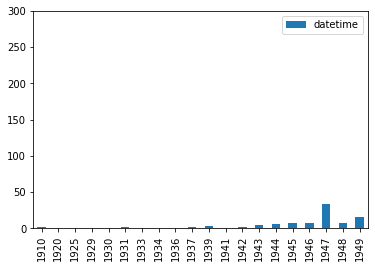

In [ ]:

pdf = df["datetime"].dt.year.value_counts()
pdf = pdf.to_frame()
pdf = pdf.sort_index()
x = pdf["datetime"]
plt = pdf[0:20].plot(kind = "bar")
plt.set_ylim(0,300)

(0.0, 300.0)

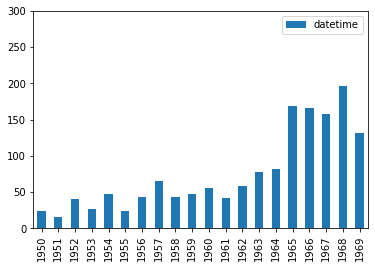

In [ ]:
plt = pdf[20:40].plot(kind = "bar")
plt.set_ylim(0,300)

(0.0, 300.0)

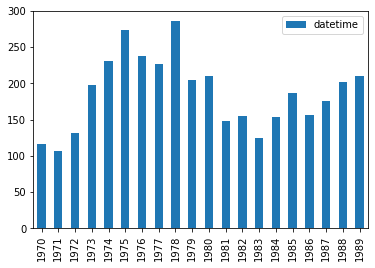

In [ ]:
plt =pdf[40:60].plot(kind = "bar")
plt.set_ylim(0,300)

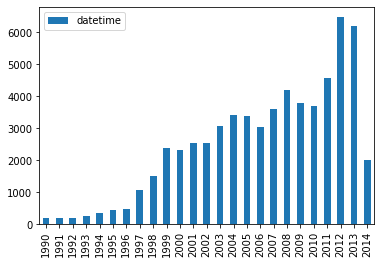

In [ ]:
pdf[60:85].plot(kind = "bar")


In [ ]:
vier_zehn =  df.loc[df['datetime'].dt.year == 2014]

vier_zehn.sort_values(by="datetime")
vier_zehn.tail()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),latitude,longitude
38973,2014-05-07 21:00:00,theodore,al,us,circle,120.000000,few minutes,30.547500,-88.175278
38974,2014-05-07 21:10:00,naugatuck,ct,us,unknown,300.000000,5 minutes,41.485832,-73.051111
38975,2014-05-07 21:20:00,hillsboro,mo,us,fireball,360.000000,4-6 minutes,38.232224,-90.562778
38976,2014-05-07 23:30:00,san isidro,nm,NaN,unknown,15.000000,15 seconds,35.563362,-106.770591
39099,2014-05-08 00:00:00,memphis,tn,us,rectangle,900.000000,15 minutes,35.149445,-90.048889


Pro Monat

July         8008
August       7050
June         6748
October      6454
September    6348
November     5836
December     4791
January      4728
April        4556
March        4552
May          4373
February     3907
Name: datetime, dtype: int64


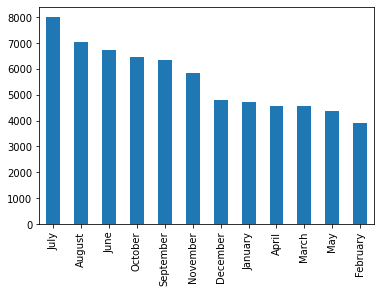

In [ ]:
print(df["datetime"].dt.month_name().value_counts())

df["datetime"].dt.month_name().value_counts().plot(kind="bar")




Pro Wochentag

Saturday     11831
Sunday        9730
Friday        9723
Wednesday     9264
Thursday      9260
Tuesday       9129
Monday        8414
Name: datetime, dtype: int64


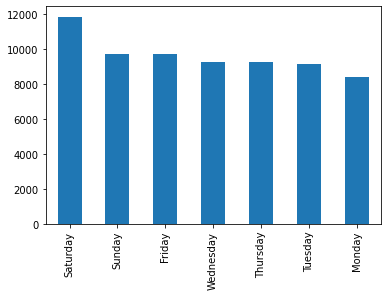

In [ ]:
print(df["datetime"].dt.day_name().value_counts())

df["datetime"].dt.day_name().value_counts().plot(kind="bar")



Tageszeit

22:00:00    3922
21:00:00    3867
23:00:00    2824
20:00:00    2763
21:30:00    2002
19:00:00    1918
00:00:00    1894
22:30:00    1792
20:30:00    1509
01:00:00    1310
Name: datetime, dtype: int64


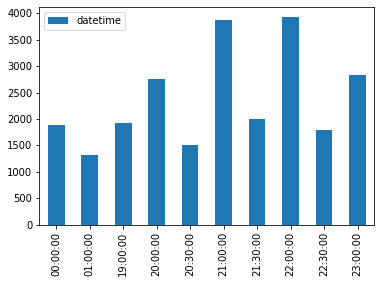

In [ ]:
print(df["datetime"].dt.time.value_counts()[0:10])
#Top 10
pdf = df["datetime"].dt.time.value_counts()
pdf = pdf.to_frame()
pdf = pdf.sort_values(by = "datetime",ascending= False)

pdf = pdf[0:10]
pdf = pdf.sort_index()
pdf.plot(kind = "bar")

Stadt

seattle        473
phoenix        438
las vegas      357
portland       355
los angeles    348
san diego      328
houston        293
chicago        257
tucson         237
miami          230
Name: city, dtype: int64


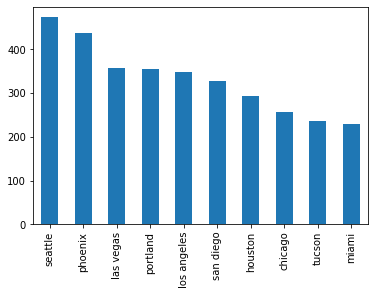

In [ ]:
print(df["city"].value_counts()[0:10])
# top 10
df["city"].value_counts()[0:10].plot(kind="bar")

Staat

In [ ]:
df["state"].value_counts()

ca    9305
fl    3773
tx    3570
wa    3453
ny    3093
az    2621
il    2587
pa    2519
oh    2397
mi    1974
nc    1721
or    1657
mo    1546
co    1474
in    1358
va    1356
nj    1339
ga    1313
wi    1304
ma    1280
tn    1161
mn    1056
sc    1031
ct     938
ky     901
nv     876
md     852
nm     785
ok     756
ut     730
ia     698
ar     650
al     649
ks     638
me     605
la     578
id     539
nh     528
mt     491
wv     475
ms     400
ne     395
hi     309
ak     308
vt     300
ri     279
wy     196
sd     189
de     174
nd     131
dc      93
Name: state, dtype: int64

In [ ]:
 pd.set_option("display.max_rows", 10)

## Sichtungsdauern von Ufosichtungen:


In [ ]:
min = df["duration (seconds)"].min()
max = df["duration (seconds)"].max()
mean = df["duration (seconds)"].mean()
print("Minimum: "+str(min))
print("Maximum: "+str(max))
print("Durschnitt: "+str(mean))


Minimum: 0.01
Maximum: 66276000.0
Durschnitt: 5603.1104761621955


# Zusammenhang mit Militärbasen

Datasheet Quelle: https://public.opendatasoft.com/explore/dataset/military-bases/
(zuletzt besucht am 06.01.21)

In [ ]:

uploaded = files.upload()
base = gdp.read_file("/content/military-bases.zip")

Saving military-bases.zip to military-bases (1).zip


In [ ]:
base

,objectid_1,objectid,component,site_name,joint_base,state_terr,country,oper_stat,perimeter,area,shape_leng,shape_area,geometry
0,5.000000,6.000000,Army Active,Pohakuloa Training Area,N/A,Hawaii,United States,Active,89.064642,205.674769,152591.132012,604225947.319437,"POLYGON ((-155.68718 19.87118, -155.68938 19.8..."
1,46.000000,101.000000,Army Active,Military Ocean Tml Sunny Point,N/A,North Carolina,United States,Active,40.630225,18.030943,80617.741163,68147513.852966,"MULTIPOLYGON (((-77.94394 34.03279, -77.94395 ..."
2,61.000000,172.000000,Army Active,Waianae Kai Military Reservation,N/A,Hawaii,United States,Active,1.015063,0.021070,1765.975570,63304.548055,"POLYGON ((-158.19297 21.44828, -158.19298 21.4..."
3,105.000000,677.000000,Army Active,Picatinny Arsenal,N/A,New Jersey,United States,Active,21.652624,10.274818,47441.757988,46701010.096659,"MULTIPOLYGON (((-74.49401 40.99037, -74.50484 ..."
4,204.000000,1412.000000,Navy Active,Arlington Service Ctr,N/A,Virginia,United States,Active,0.803040,0.030300,1713.357672,129642.211008,"POLYGON ((-77.07863 38.86896, -77.07813 38.868..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,615.000000,5424.000000,Navy Active,Wahiawa,Joint Base Pearl Harbor - Hickam,Hawaii,United States,Active,7.113096,1.073077,12384.851769,3227227.351359,"POLYGON ((-158.01972 21.51818, -158.02220 21.5..."
772,664.000000,5610.000000,Navy Active,Dandan,Joint Region Marianas,Guam,Guam,Active,2.034633,0.248449,3307.200322,683591.012215,"POLYGON ((144.74050 13.31001, 144.74050 13.309..."
773,673.000000,5642.000000,Navy Active,SPAWARS South,N/A,California,United States,Active,1.425920,0.077609,2795.917591,284443.745165,"POLYGON ((-117.23821 32.66662, -117.23833 32.6..."
774,712.000000,5831.000000,AF Active,Rome Laboratory,N/A,New York,United States,Active,3.493360,0.130984,7971.688355,639130.857005,"MULTIPOLYGON (((-75.40919 43.21857, -75.41173 ..."


In [ ]:
df_geo = gdp.GeoDataFrame(df,geometry=gdp.points_from_xy(df.longitude, df.latitude ))


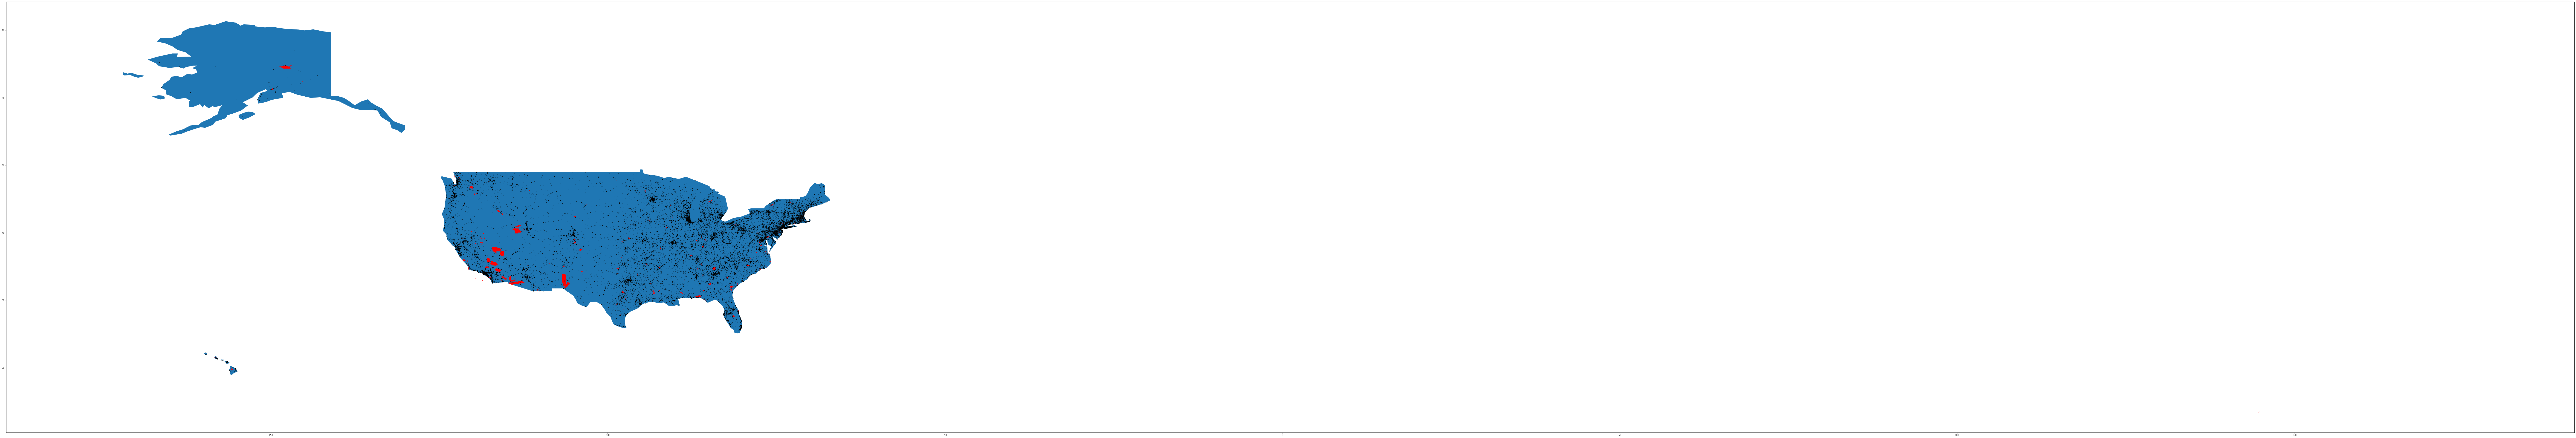

In [ ]:
us = world_data[world_data.name == "United States of America"].plot(figsize=(200,200))
axis = base.plot(ax = us, color = "red",figsize=(200,200))
df_geo.plot(markersize=1, ax = axis, color = "black",figsize=(200,200))


# Form und Jahreszeit



Jahreszeiten laut : https://www.calendarr.com/united-states/seasons-of-the-year-in-the-united-states/ ( zuletzt besucht am 06.01.21)



    Spring: March 20, at 5:37 A.M.
    Summer: June 20, at 11:32 P.M.
    Fall: September 22, at 3:21 P.M.
    Winter: December 21, at 10:59 A.M.


In [ ]:
#range entspricht Tag des Jahres 
spring = range(79,171)
summer = range(172,265)
fall = range(266,355)
#winter = else
def season(day : int):
  if day in spring:
    return "spring"
  if day in summer:
    return "summer"
  if day in fall:
    return "fall"
  else:
    return "winter"  

    
for i in df.index:
  df.at[i,"season"] = season(df.iloc[i]["datetime"].dayofyear)


In [ ]:
df

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),latitude,longitude,geometry,season
0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700.000000,45 minutes,29.883055,-97.941111,POINT (-97.94111 29.88305),fall
1,1949-10-10 21:00:00,lackland afb,tx,NaN,light,7200.000000,1-2 hrs,29.384210,-98.581082,POINT (-98.58108 29.38421),fall
2,1956-10-10 21:00:00,edna,tx,us,circle,20.000000,1/2 hour,28.978333,-96.645833,POINT (-96.64583 28.97833),fall
3,1960-10-10 20:00:00,kaneohe,hi,us,light,900.000000,15 minutes,21.418056,-157.803611,POINT (-157.80361 21.41806),fall
4,1961-10-10 19:00:00,bristol,tn,us,sphere,300.000000,5 minutes,36.595000,-82.188889,POINT (-82.18889 36.59500),fall
...,...,...,...,...,...,...,...,...,...,...,...
67346,2013-09-09 21:15:00,nashville,tn,us,light,600.000000,10 minutes,36.165833,-86.784444,POINT (-86.78444 36.16583),summer
67347,2013-09-09 22:00:00,boise,id,us,circle,1200.000000,20 minutes,43.613610,-116.202500,POINT (-116.20250 43.61361),summer
67348,2013-09-09 22:00:00,napa,ca,us,other,1200.000000,hour,38.297222,-122.284444,POINT (-122.28444 38.29722),summer
67349,2013-09-09 22:20:00,vienna,va,us,circle,5.000000,5 seconds,38.901110,-77.265556,POINT (-77.26556 38.90111),summer


In [ ]:
spring = df.loc[df['season'] == "spring"]
summer =df.loc[df['season'] == "summer"]
winter = df.loc[df['season'] == "winter"]
fall = df.loc[df['season'] == "fall"]
seasons = [spring,summer,winter,fall]

    season      shape  counts
14  spring      light    2966
20  spring   triangle    1567
3   spring     circle    1401
9   spring       disk    1194
15  spring      other    1111
18  spring     sphere    1089
21  spring    unknown    1070
11  spring   fireball     902
16  spring       oval     740
13  spring  formation     462
----------------------------------------------------------------------------------------------------
    season     shape  counts
15  summer     light    4797
4   summer    circle    2120
21  summer  triangle    2074
12  summer  fireball    1858
22  summer   unknown    1541
19  summer    sphere    1536
10  summer      disk    1503
16  summer     other    1462
17  summer      oval    1036
3   summer     cigar     651
----------------------------------------------------------------------------------------------------
    season      shape  counts
15  winter      light    2934
22  winter   triangle    1466
3   winter     circle    1338
12  winter   fireball    1145

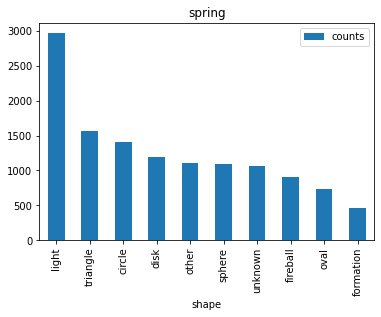

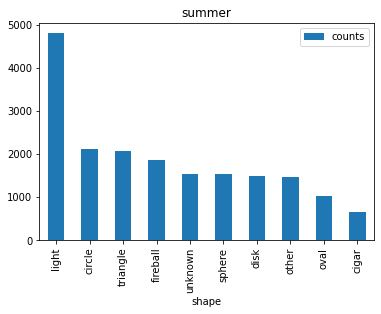

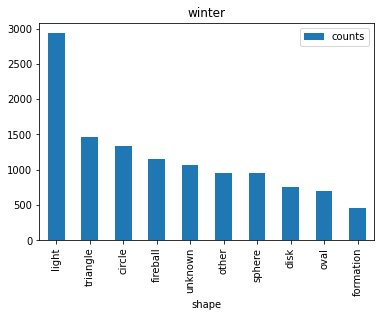

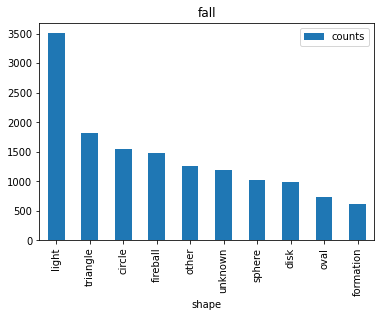

In [ ]:
for frames in seasons:
  season = frames.iloc[0]["season"]
  print(frames.groupby(["season", "shape"]).size().reset_index(name="counts").sort_values(by = "counts",ascending = False)[0:10])
  frames.groupby(["season", "shape"]).size().reset_index(name="counts").sort_values(by = "counts",ascending = False)[0:10].plot(kind = "bar",x="shape",y = "counts",title =str(season) )
  print(100*"-")




## Verschiedene individuelle Fragen:


Form der allerersten Ufosichtung


In [ ]:
df.iloc[0]["shape"]

'cylinder'

Durchschnittliche Sichtungsdauer pro Form


In [ ]:
pdf = df.groupby(['shape'])["duration (seconds)"].mean().sort_values(ascending=False)


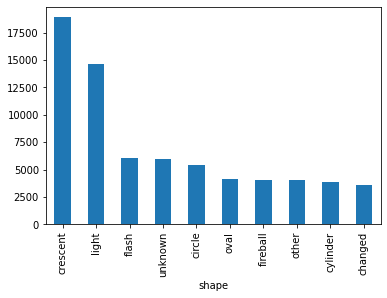

In [ ]:
#Top 10
pdf[0:10].plot(kind = "bar")

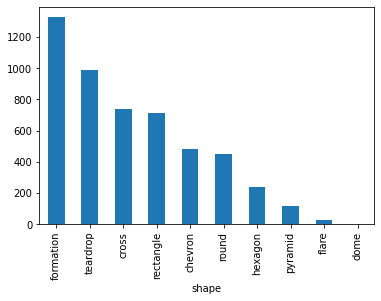

In [ ]:
#Letzten 10
pdf[-10:].plot(kind = "bar")


Ort wo Form am häufigsten pro Form

Quelle: https://stackoverflow.com/questions/29836477/pandas-create-new-column-with-count-from-groupby (zuletzt besucht am 06.01.2021)






In [ ]:
df['Counts'] = np.zeros(len(df))
grp_df = df.groupby(['shape', 'state']).count()
grp_df

datetime  city  country  duration (seconds)  \
shape    state                                                
changed  co            1     1        1                   1   
changing ak            5     5        5                   5   
         al           12    12       11                  12   
         ar           19    19       18                  19   
         az           77    77       70                  77   
...                  ...   ...      ...                 ...   
unknown  vt           23    23       17                  23   
         wa          277   277      254                 277   
         wi          105   105       97                 105   
         wv           42    42       40                  42   
         wy           12    12        9                  12   

                duration (hours/min)  latitude  longitude  geometry  season  \
shape    state                                                                
changed  co                        1         1          1         1       1   
changing ak                        5         5          5         5       5   
         al                       12        12         12        12      12   
         ar                       19        19         19        19      19   
         az                       77        77         77        77      77   
...                              ...       ...        ...       ...     ...   
unknown  vt                       23        23         23        23      23   
         wa                      277       277        277       277     277   
         wi                      105       105        105       105     105   
         wv                       42        42         42        42      42   
         wy                       12        12         12        12      12   

                Counts  
shape    state          
changed  co          1  
changing ak          5  
         al         12  
         ar         19  
         az         77  
...                ...  
unknown  vt         23  
         wa        277  
         wi        105  
         wv         42  
         wy         12  

[1063 rows x 10 columns]

In [ ]:

grp_df = grp_df.reset_index(level=[0,1])
grouped = grp_df
grp_df


,shape,state,datetime,city,country,duration (seconds),duration (hours/min),latitude,longitude,geometry,season,Counts
0,changed,co,1,1,1,1,1,1,1,1,1,1
1,changing,ak,5,5,5,5,5,5,5,5,5,5
2,changing,al,12,12,11,12,12,12,12,12,12,12
3,changing,ar,19,19,18,19,19,19,19,19,19,19
4,changing,az,77,77,70,77,77,77,77,77,77,77
...,...,...,...,...,...,...,...,...,...,...,...,...
1058,unknown,vt,23,23,17,23,23,23,23,23,23,23
1059,unknown,wa,277,277,254,277,277,277,277,277,277,277
1060,unknown,wi,105,105,97,105,105,105,105,105,105,105
1061,unknown,wv,42,42,40,42,42,42,42,42,42,42


In [ ]:
shapes = df["shape"].unique()
liste =  []
for state in shapes:
  tup = tuple([state, " ", 0])

  liste.append(tup)



for tup in shapes:

  tup = (tup[0],"",0)
  for i in grouped.index:
    shape = grouped.iloc[i]["shape"]
    state =  grouped.iloc[i]["state"]
    count =  grouped.iloc[i]["Counts"]
    tup = (shape,state,count)
    for i in range(len(liste)):
        if liste[i][0] == shape and liste[i][2]<count:
          liste[i] = tup
      




In [ ]:
print ("Form       Staat       Anzahl ")
for ele1,ele2,ele3 in liste:
    print ("{:<14}{:<11}{}".format(ele1,ele2,ele3))

Form       Staat       Anzahl 
cylinder      ca         133
light         ca         1959
circle        ca         894
sphere        ca         671
disk          ca         687
fireball      ca         735
unknown       ca         598
oval          ca         417
other         ca         671
rectangle     ca         157
chevron       ca         157
formation     ca         312
triangle      ca         878
cigar         ca         211
delta         ga         1
changing      ca         288
flash         ca         150
egg           ca         94
diamond       ca         151
teardrop      ca         77
cone          ca         31
cross         ca         32
pyramid       mn         1
round         ca         1
crescent      nh         1
flare         ca         1
hexagon       pa         1
dome          pa         1
changed       co         1
